In [20]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pymc3 as pm
import arviz as az

## Example

In [2]:
with pm.Model() as norm:
  x = pm.Normal("x", mu=0, sigma=1)

In [3]:
norm.x

x ~ Normal

In [4]:
x

x ~ Normal

In [5]:
x = 1

In [6]:
norm.x

x ~ Normal

In [7]:
with pm.Model() as beta_binom:
  p = pm.Beta("p", alpha=10, beta=10)
  x = pm.Binomial("x", n=20, p=p, observed=5)

In [10]:
beta_binom.free_RVs


[p_logodds__ ~ TransformedDistribution]

In [12]:
beta_binom.observed_RVs

[x ~ Binomial]

In [13]:
with beta_binom:
  trace = pm.sample(return_inferencedata=True, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [14]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# Demo 1 - Linear regression

Given the below data, we want fit a Bayesian linear regression model to the following synthetic data,

In [15]:
np.random.seed(1234)
n = 11
m = 6
b = 2
x = np.linspace(0, 1, n)
y = m*x + b + np.random.randn(n)

In [16]:
with pm.Model() as lm:
    m = pm.Normal("m", mu=0, sd=10)
    b = pm.Normal("b", mu=0, sd=10)
    sigma = pm.HalfNormal("sigma", sd=10)
    
    likelihood = pm.Normal("y", mu=m*x + b, sd=sigma, observed=y) 
    

In [17]:
with lm:
    trace = pm.sample(return_inferencedata=True, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [21]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,5.498,1.447,2.745,8.166,0.045,0.032,1080.0,1030.0,1.00
b,2.230,0.840,0.686,3.825,0.027,0.021,1055.0,976.0,1.01
sigma,1.390,0.423,0.776,2.182,0.012,0.009,1126.0,980.0,1.01


array([[<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

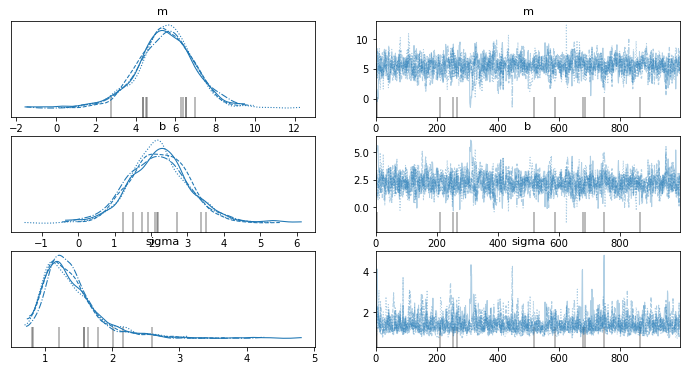

In [22]:
az.plot_trace(trace)

array([<AxesSubplot:title={'center':'m'}>,
       <AxesSubplot:title={'center':'b'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

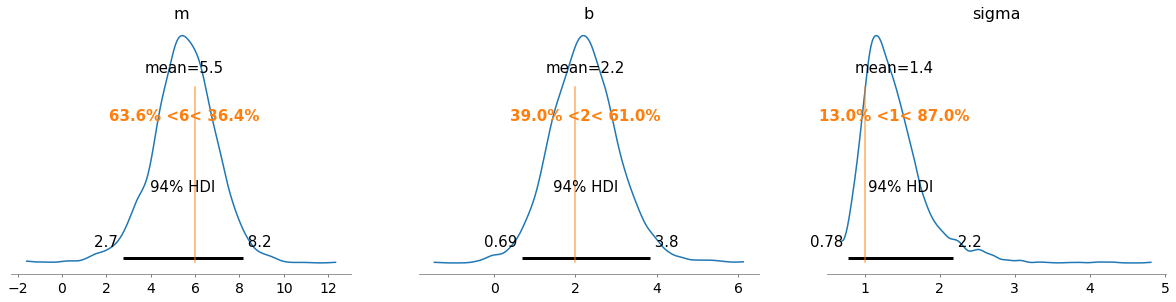

In [24]:
az.plot_posterior(trace, ref_val=[6,2,1])

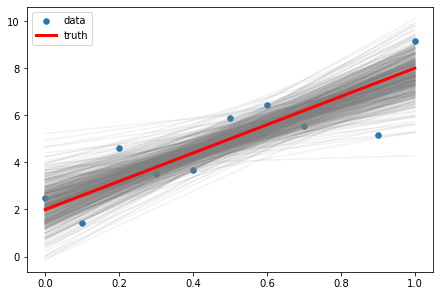

In [36]:
post_m = trace.posterior['m'][0, -500:].values
post_b = trace.posterior['b'][0, -500:].values

plt.figure(layout="constrained")
plt.scatter(x,y,s=30, label="data")

for m, b in zip(post_m, post_b):
    plt.plot(x, m*x+b, c='grey', alpha=0.1)
    
plt.plot(x, 6*x+2, label="truth", lw=3, c='red')
plt.legend()
plt.show()

In [38]:
with lm:
    pp = pm.sample_posterior_predictive(trace, samples=200)

In [40]:
pp["y"].shape

(200, 11)

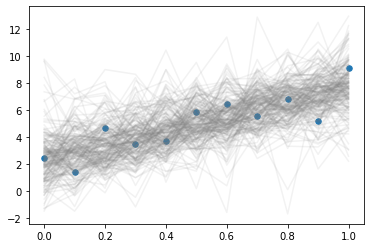

In [41]:
plt.figure()
plt.plot(x, pp["y"].T, c="grey", alpha=0.1)
plt.scatter(x,y,s=30, label="data")
plt.show()

In [44]:
with pm.Model() as lm:
    m = pm.Normal("m", mu=0, sd=10)
    b = pm.Normal("b", mu=0, sd=10)
    sigma = pm.HalfNormal("sigma", sd=10)
    
    y_est = pm.Deterministic("y_est", m*x + b)
    
    likelihood = pm.Normal("y", mu=y_est, sd=sigma, observed=y) 
    
    trace = pm.sample(return_inferencedata=True, random_seed=1234)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [49]:
with lm:
    pp = pm.sample_posterior_predictive(trace, samples=200, var_names = ["y_est"])

In [50]:
pp

{'y_est': array([[4.09382539, 4.21630389, 4.33878238, ..., 5.07365335, 5.19613184,
         5.31861034],
        [5.39739084, 5.51965248, 5.64191411, ..., 6.37548392, 6.49774555,
         6.62000718],
        [4.98805903, 5.06275178, 5.13744453, ..., 5.58560102, 5.66029377,
         5.73498652],
        ...,
        [1.97883211, 2.52883988, 3.07884764, ..., 6.37889424, 6.928902  ,
         7.47890977],
        [2.22460706, 2.80966228, 3.3947175 , ..., 6.90504882, 7.49010405,
         8.07515927],
        [1.39502969, 1.98550406, 2.57597844, ..., 6.11882469, 6.70929907,
         7.29977345]])}

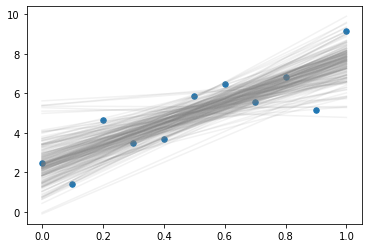

In [51]:
plt.figure()
plt.plot(x, pp["y_est"].T, c="grey", alpha=0.1)
plt.scatter(x,y,s=30, label="data")
plt.show()

# Demo 2 - Bayesian Lasso

Below is synthetic data representing a sparse (underdetermined) system that we would like to model, our goal is to compare a Bayesian linear regression model with a Lasso model and compare their performance

In [ ]:
n = 50
k = 100

np.random.seed(1234)
X = np.random.normal(size=(n, k))

beta = np.zeros(shape=k)
beta[[10,30,50,70]] =  10
beta[[20,40,60,80]] = -10

y = X @ beta + np.random.normal(size=n)

In [ ]:
## Plot helper

def plot_slope(trace, prior="beta", chain=0):
  post = (trace.posterior[prior]
          .to_dataframe()
          .reset_index()
          .query(f"chain == {chain}")
         )
  
  sns.catplot(x="beta_dim_0", y="beta", data=post, kind="boxen", linewidth=0, color='blue', aspect=2, showfliers=False)
  plt.tight_layout()
  plt.show()
  